<a href="https://colab.research.google.com/github/andrewbowen19/mastersThesisData698/blob/main/GNN_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --q torch_geometric

In [14]:
import torch_geometric
from torch_geometric.datasets import Reddit
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [3]:
class DataCleaner:

  def __init__(self):
    pass

  @staticmethod
  def snake_case_columns(df: DataFrame) -> DataFrame:
    """Convert all columns in a pandas DataFrame to `snake_case`"""
    new_cols = [c.lower().replace(" ", "_").replace("-", "_") for c in df.columns]

    df.columns = new_cols
    return df

  @staticmethod
  def trim_whitespace(df: DataFrame) -> DataFrame:
    """Trim all leading and trailing whitespace"""
    for c in df.columns:
      if isinstance(df.dtypes[c], np.dtypes.ObjectDType):
        df[c] = df[c].str.strip()
    return df

  @staticmethod
  def date_parser(df: DataFrame, column_name: str, format: str = "%m/%d/%y") -> DataFrame:
    """Parse date-like columns in a dataframe"""
    df[column_name] = pd.to_datetime(df[column_name], format=format)
    return df

cleaner = DataCleaner()


## Datasets

The [CEDR Data Catalog](https://oriseapps.orau.gov/cedr/pdf/cedr-catalog-2021-508.pdf) is a good resource with documentation on the available datasets from the database.

- [Dataset 1](https://oriseapps.orau.gov/cedr/search_results.aspx?DataSet=MFMM98W1)
- [Dataset 2](https://oriseapps.orau.gov/cedr/search_results.aspx?DataSet=MFMM98W2)

## Reading in and Preprocessing our datasets

The datasets are available for [download here](https://oriseapps.orau.gov/cedr/search_results.aspx?DataSet=MFMM98W1). There are chemical agent, industrial hygiene, and building lists for the below sites:

- Hanford Site
- Los Alamos Natinoal Laboratory
- Savannah River Site
- Oak Ridge National Laboratory

We'll need to do some data wrangling before we put this into a [`HeteroData` dataset suitable for PyG](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.HeteroData.html#torch_geometric.data.HeteroData)

In [4]:
site_mapping = {
    "Hanford Site": {"code": "hanford",
                     "filename_prefix": "Hanford"},
    "Los Alamos National Laboratory": {"code": "lanl",
                     "filename_prefix": "LANL"},
    "Savannah River Site": {"code": "srs",
                     "filename_prefix": "SRS"},
    "Oak Ridge National Laboratory": {"code": "ornl",
                     "filename_prefix": "ORNL"},
}

data_types = ["Buildings", "ChemicalAgents", "IH"]

def construct_df(data_type: str = "Buildings"):
  dfs = []
  for site, info in site_mapping.items():
    prefix = info.get("filename_prefix")
    filename = f"/content/{prefix}-{data_type}.csv"

    dat = pd.read_csv(filename)
    dfs.append(dat)


  df = pd.concat(dfs)

  return df

# Read in datasets and combine across sites
buildings = construct_df("Buildings")
agents = construct_df("ChemicalAgents")
ih_data = construct_df("IH")

In [5]:
# Do some basic data cleaning/preprocessing

# Trim whitespace
buildings = cleaner.snake_case_columns(buildings)
agents = cleaner.snake_case_columns(agents)
ih_data = cleaner.snake_case_columns(ih_data)

buildings = cleaner.trim_whitespace(buildings)
agents = cleaner.trim_whitespace(agents)
ih_data = cleaner.trim_whitespace(ih_data)



In [6]:
ih_data.head()

,agent,date,dep_grp,descript,facility,jobtitle,location,quantity,referenc,room,sampleid,site,type,uom,seq_no
0,mercury,12/22/81,100N,"06686:Mercury survey lift station; n=1, airbor...",HANF,,,0.010000,HEX78_83,,122281_001,,BZ,mg/m3,1
1,benzene,4/24/81,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.058000,HEX78_83,,042481_001,,BZ,ppm,2
2,benzene,7/30/81,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.125000,HEX78_83,,073081_001,,BZ,ppm,3
3,benzene,7/31/81,1100,06200:Personnel and breathing zone samples of ...,HANF,623,,0.030000,HEX78_83,,073181_001,,BZ,ppm,4
4,formaldehyde,9/1/81,1100,06476:Impinger samples collected between 1100 ...,HANF,HO5,,0.195000,HEX78_83,,090181_001,,BZ,ppm,5


In [7]:
# # convert dates
# buildings = cleaner.date_parser(buildings, "date")
# ih_data = cleaner.date_parser(ih_data, "date")
# ih_data = cleaner.date_parser(ih_data, "date")
# ih_data = cleaner.date_parser(ih_data, "begdate")

In [8]:
# convert IDs (seq_no) to int types
buildings.dtypes['seq_no'] = buildings['seq_no'].astype(int)
ih_data.dtypes['seq_no'] = ih_data['seq_no'].astype(int)

## Converting to a Graph Dataset

In our case, the nodes fo our grpah represent different types of entities. Hence, we'll need to constrct the a dataset representing a [heterogeneous graph for PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html?highlight=heterogeneous%20graph#creating-heterogeneous-graphs)

In [9]:
# Lookup the building ID number

buildings['building_id'] = buildings['seq_no']

ih_data = ih_data.merge(buildings[['location', 'building_id']], on="location", how="inner")


In [10]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData


# Assuming the CSV files have columns like 'seq_no', 'seq_no', 'Relationship', etc.

# Create nodes for buildings and chemicals
building_nodes = buildings['seq_no'].unique()
chemical_nodes = ih_data['seq_no'].unique()

# Create edge types based on the relationship between buildings and chemicals
edge_types = ih_data['location'].unique()

# Create dictionary to store node indices for each node type
node_to_index = {}
for node_type, nodes in zip(['building', 'chemical'], [building_nodes, chemical_nodes]):
    node_to_index[node_type] = {node: index for index, node in enumerate(nodes)}

# Create dictionary to store edge indices for each edge type
edge_index_dict = {edge_type: [] for edge_type in edge_types}
for index, row in ih_data.iterrows():
    building_id = row['building_id']
    chemical_id = row['seq_no']
    relationship = row['location']
    src_index = node_to_index['building'][building_id]
    tgt_index = node_to_index['chemical'][chemical_id]
    edge_index_dict[relationship].append((src_index, tgt_index))

# Convert nodes to node indices
building_indices = torch.tensor(list(node_to_index['building'].values()), dtype=torch.long)
chemical_indices = torch.tensor(list(node_to_index['chemical'].values()), dtype=torch.long)

# Create a HeteroData object
data = HeteroData()

# TODO - add in site/facility for graph grouping/condensation
# Add nodes to the HeteroData object
data['building'].x = building_indices
data['chemical'].x = chemical_indices

# Add edges to the HeteroData object
for edge_type, edge_index_list in edge_index_dict.items():
    src, tgt = zip(*edge_index_list)
    data[edge_type] = torch.tensor([src, tgt], dtype=torch.long)


In [36]:
edge_types

array(['202-S', '209-E', '305', '308', '313', '314', '321', '324', '325',
       '326', '327', '328', '329', '331', '333', '337', '338', '3706',
       '3716', '3720', '3731', '3760', '384', 'FED', '340', 'TA-40',
       '200', '304', '306', '301', '307', '102', '105', '114', 'TA-22',
       '100', '105-C', '221-F', '221-H', '232-H', '234-H', '244-H',
       '299-H', '300-M', '305-M', '313-M', '320-M', '321-M', '322-M',
       '400-D', '412-D', '484-D', '678-G', '702-A', '703-A', '704-D',
       '713-A', '716-A', '717-A', '717-D', '717-F', '719-A', '723-A',
       '734-A', '735-A', '772-D', '772-F', '773-A', '777-M', '786-A',
       '677-G', '1000', '101', '101-C', '1504', '1505', '2000', '2001',
       '2005', '2007', '2011', '2013', '2024', '2026', '2506', '2519',
       '2525', '2528', '2567', '3000', '3003', '3005', '3012', '3017',
       '3019', '3025', '3026', '3029', '3033', '3034', '3036', '3038',
       '3042', '3044', '3047', '3074', '3104', '3500', '3502', '3503',
       '35

In [35]:
graph.edges

OutEdgeView([])

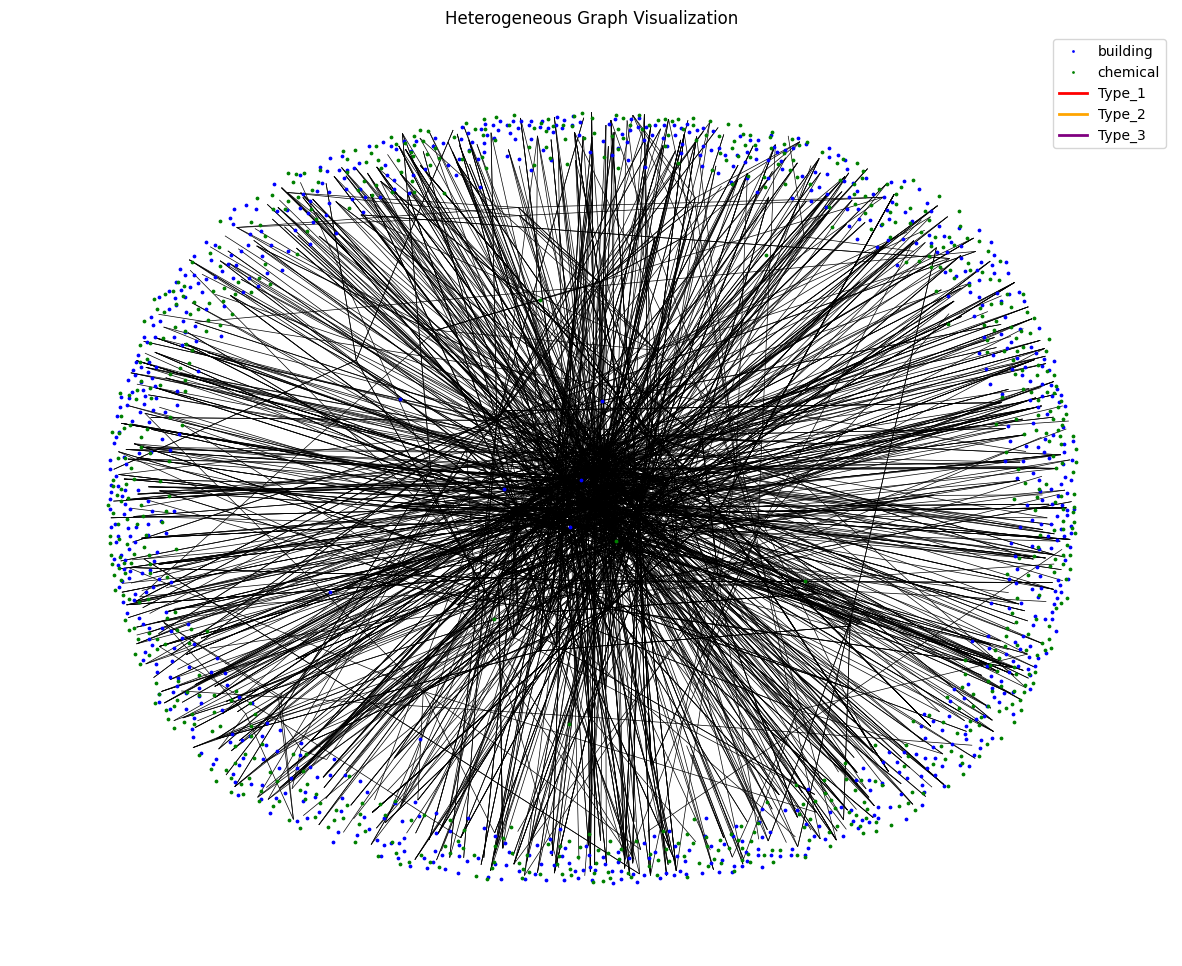

In [39]:
# Visualizing our graph dataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert HeteroData to NetworkX graph
graph = to_networkx(data)

# Visualize the NetworkX graph
plt.figure(figsize=(15, 12))

# Draw nodes for each type with different colors
node_colors = {'building': 'blue', 'chemical': 'green'}
for node_type in node_colors.keys():
    nodes = [node for node, data in graph.nodes(data=True) if data['type'] == node_type]
    nx.draw_networkx_nodes(graph, pos=nx.spring_layout(graph), nodelist=nodes, node_color=node_colors[node_type], node_size=3,
label=None)


# Draw edges representing relationship between buildings and agents
for edge_type in edge_types:
    edges = data[edge_type].t().tolist()
    graph.add_edges_from(edges, type=edge_type)
nx.draw_networkx_edges(graph, pos=nx.spring_layout(graph), edge_color='black', arrows=False, width=0.5)


# Add labels
# nx.draw_networkx_labels(graph, pos=nx.spring_layout(graph))

# Add legend
node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=3, label=label) for label, color in node_colors.items()]
edge_legend = [plt.Line2D([0], [0], color=color, lw=2, label=label) for label, color in edge_colors.items()]
plt.legend(handles=node_legend + edge_legend)

plt.title("Heterogeneous Graph Visualization")
plt.axis('off')
plt.show()


## Model Building


TODO: Parse this code from the [PyG tutorial](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html)

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        # self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

TypeError: '>' not supported between instances of 'dict' and 'int'

In [ ]:
from torch_geometric.explain import Explainer
import networkx as nx

In [ ]:
e = Explainer(model, )

In [ ]:
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)